In [1]:
import sys
sys.path.append("..")

import pandas as pd 
from channeling_lib import save_figure, load_path, load_aws_calibration_data, compute_t_stat, mean_wind_direction
import os
import glob
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
# import seaborn as sns
import re




# Specify general folder:
aws_Cal_path = load_path()+'CalibratedData/AWS/'
arome_path = load_path()+ 'ModelOutput/AromeArctic/'


stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']
# FROM LOW TO HIGH
stations_to_plot = ["Layla", "Rosanna"]  # For pressure only

# color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#b38a00']


instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

In [2]:
# Load all AWS calibrated data
aws_Cal_data = load_aws_calibration_data(aws_Cal_path, stations_str)

# Load AromeArctic Data
aromeArctic_data = xr.load_dataset(arome_path + 'AromeArctic_2p5km_MERGED_during_storm.nc')

In [3]:
aws_hourly_data = {}

for i, station in enumerate(stations_str):
    aws_hourly_data[station] = aws_Cal_data[station].resample('h').mean()
    # Add a column for station name
    aws_hourly_data[station]['Station'] = station 
    aws_hourly_data[station]['wind_direction'] = aws_Cal_data[station].wind_direction.resample('h').apply(mean_wind_direction)

In [4]:
def match_data_length(model_data, actual_data):
    """
    Ensures model_data and actual_data have the same length by trimming the longer one.

    Parameters:
    - model_data: Pandas Series, NumPy array, or xarray DataArray.
    - actual_data: Pandas Series.

    Returns:
    - Trimmed model_data and actual_data with matching length.
    """

    # Convert model data if it's an xarray DataArray
    if isinstance(model_data, xr.DataArray):
        model_data = model_data.to_series()

    # Ensure both are Pandas Series (if they are not NumPy arrays)
    if isinstance(model_data, np.ndarray):
        model_data = pd.Series(model_data)
    if isinstance(actual_data, np.ndarray):
        actual_data = pd.Series(actual_data)

    # Align time index if necessary
    if isinstance(model_data, pd.Series) and isinstance(actual_data, pd.Series):
        # Intersect indices to ensure alignment
        common_index = model_data.index.intersection(actual_data.index)
        model_data = model_data.loc[common_index]
        actual_data = actual_data.loc[common_index]

    # Find the minimum length
    min_length = min(len(model_data), len(actual_data))

    # Trim both datasets
    model_data = model_data.iloc[:min_length]
    actual_data = actual_data.iloc[:min_length]

    return model_data, actual_data

Function to generate comparative plots

Wind Speed for arome arctic is modelled at 10 m. We take it down to 2 m

U_2 = WS * (2/10)^0.16

In [5]:
aromeArctic_data['wind_speed_10m'] = aromeArctic_data['wind_speed_10m']*(2/10)**0.16

<>:138: SyntaxWarning: invalid escape sequence '\o'
<>:138: SyntaxWarning: invalid escape sequence '\e'
<>:138: SyntaxWarning: invalid escape sequence '\o'
<>:138: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alber\AppData\Local\Temp\ipykernel_31048\3406112883.py:138: SyntaxWarning: invalid escape sequence '\o'
  f'$\overline{{\epsilon}}$: {error_mean}\n'
C:\Users\alber\AppData\Local\Temp\ipykernel_31048\3406112883.py:138: SyntaxWarning: invalid escape sequence '\e'
  f'$\overline{{\epsilon}}$: {error_mean}\n'


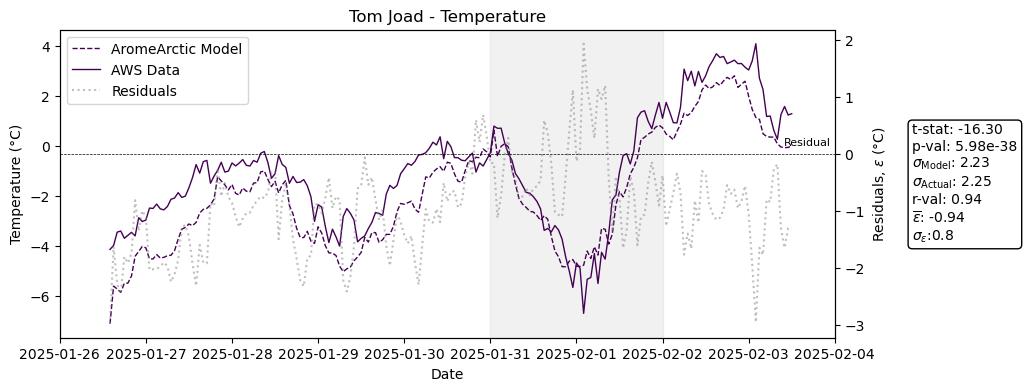

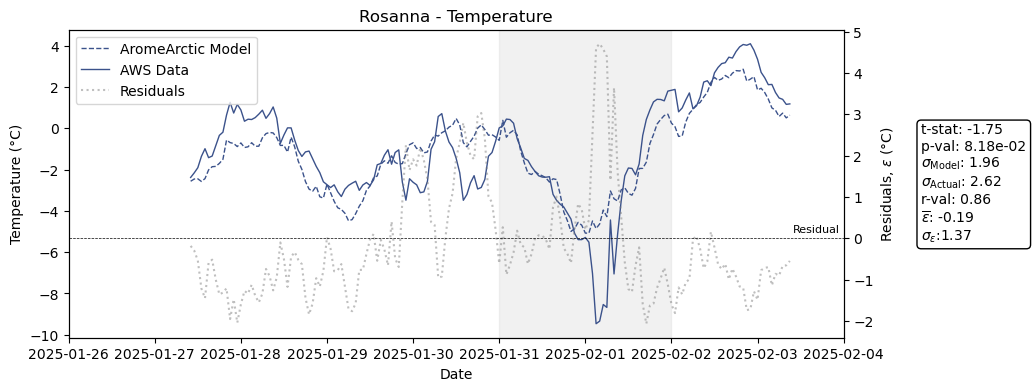

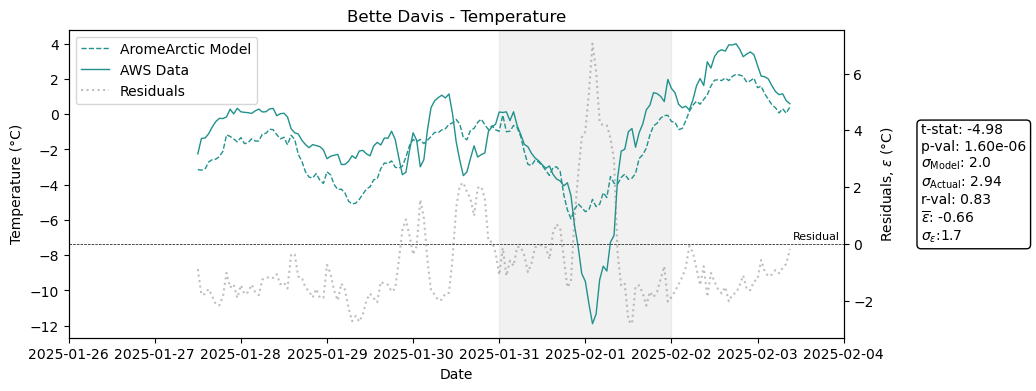

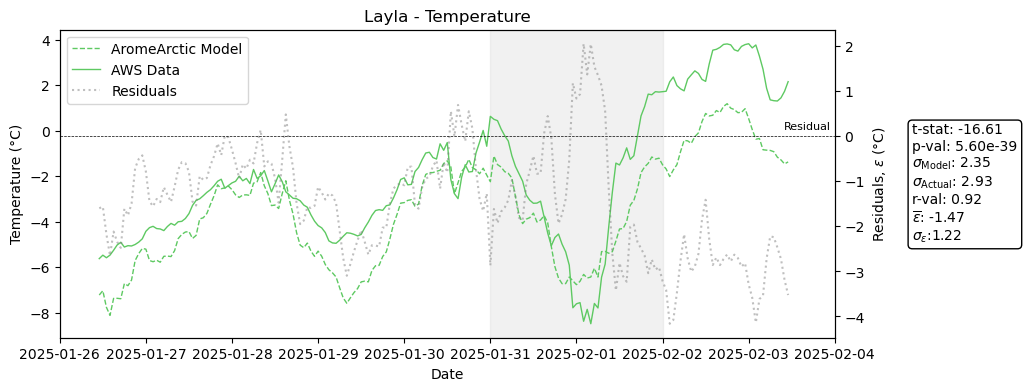

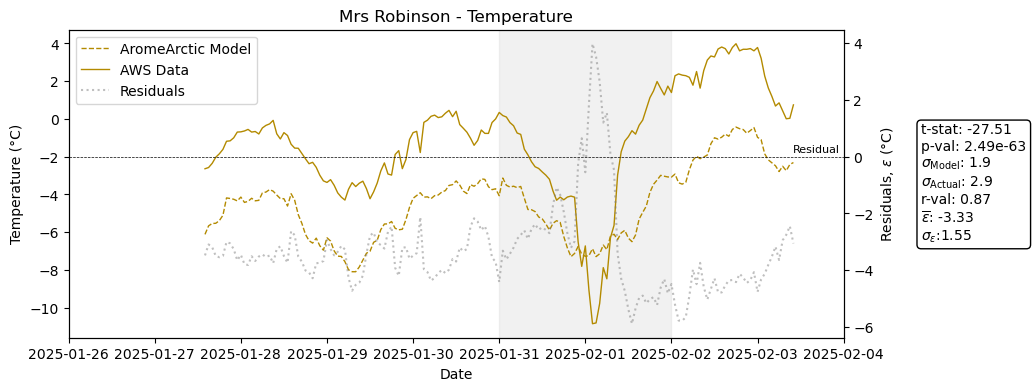

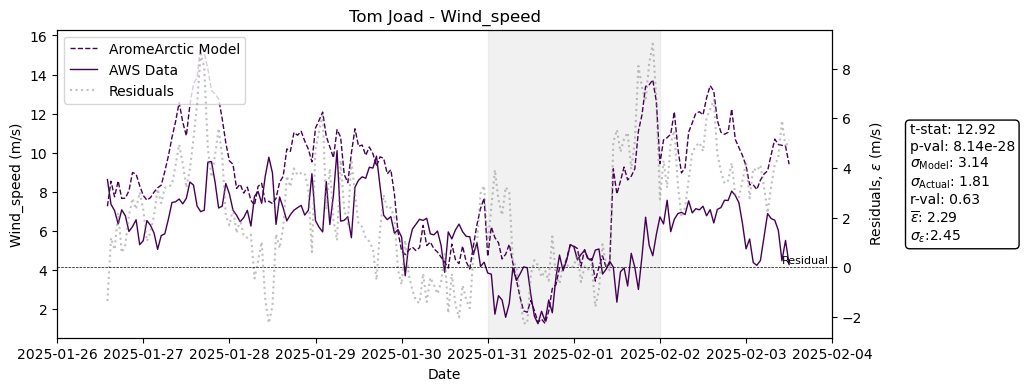

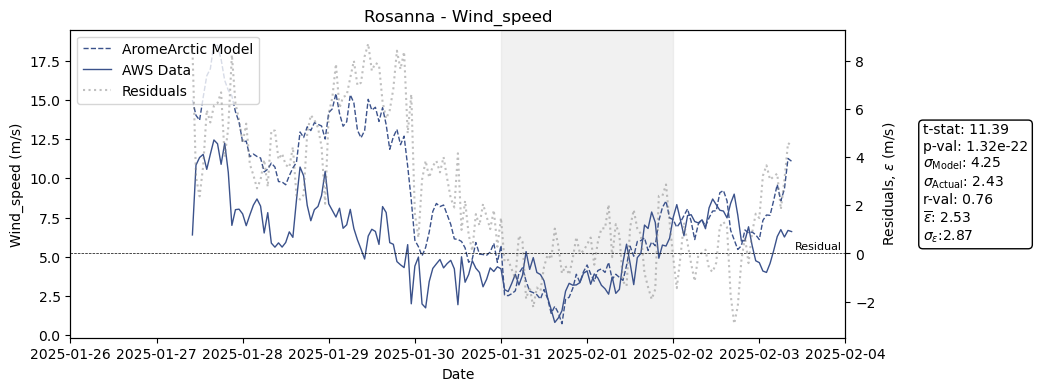

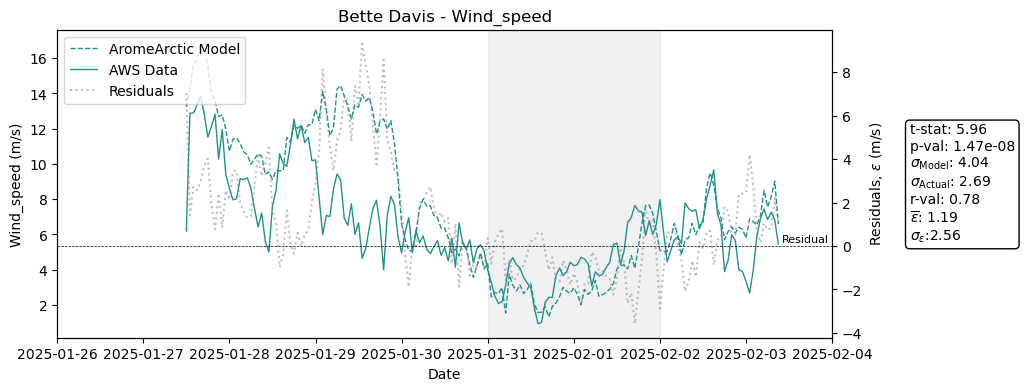

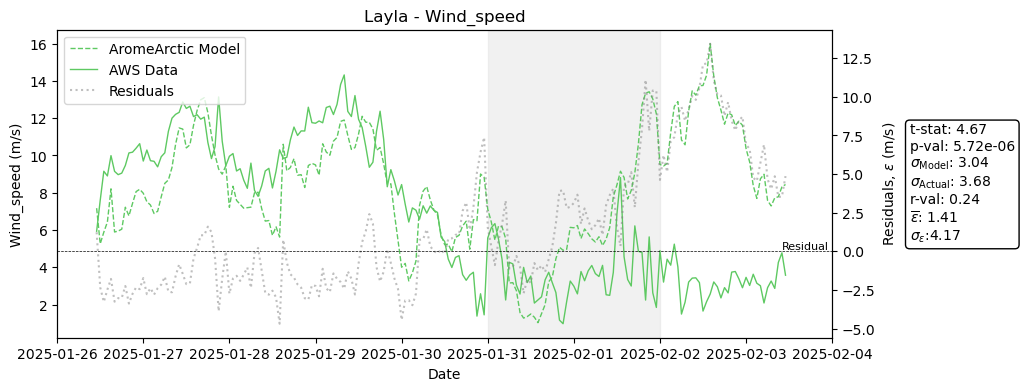

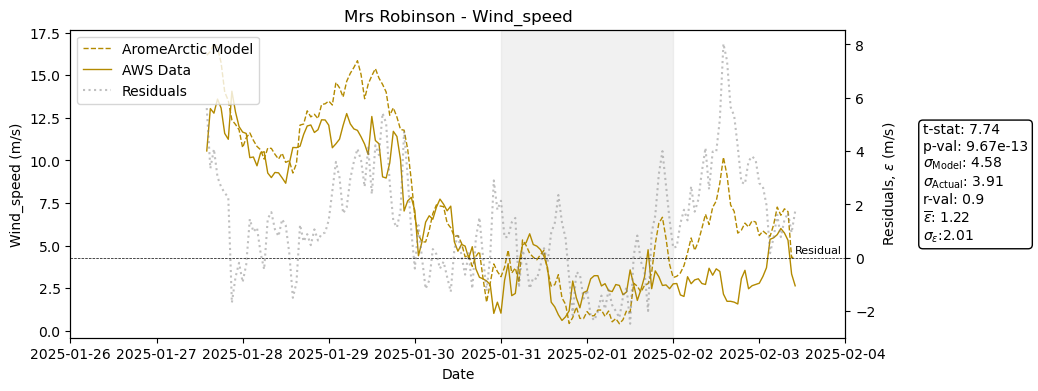

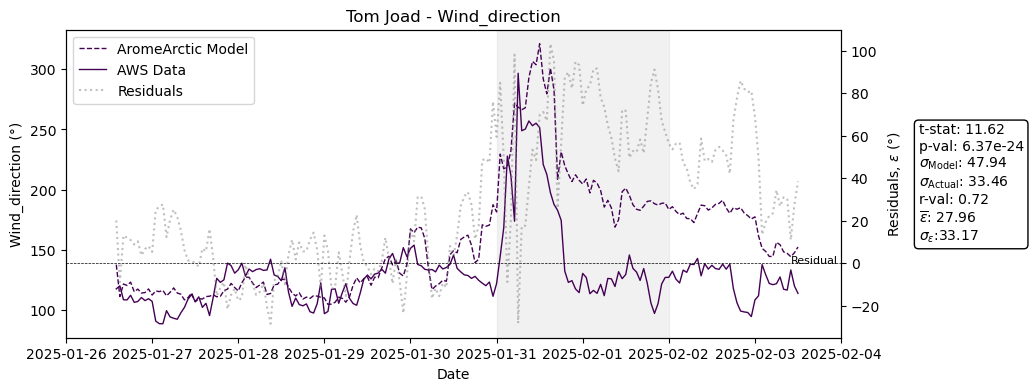

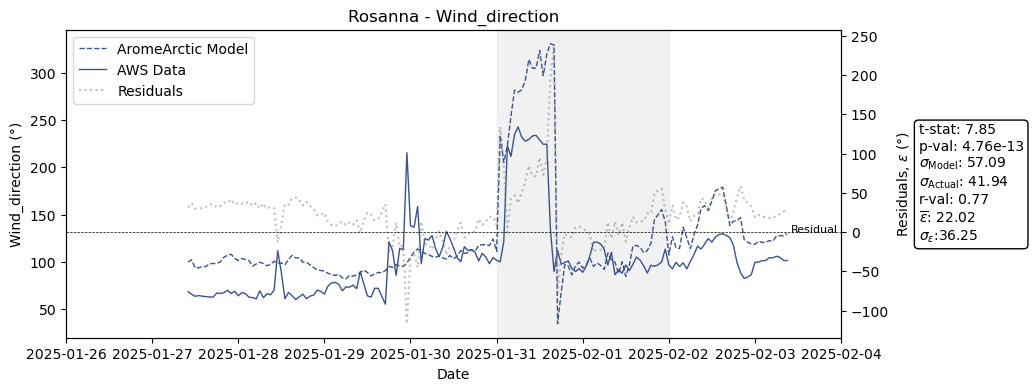

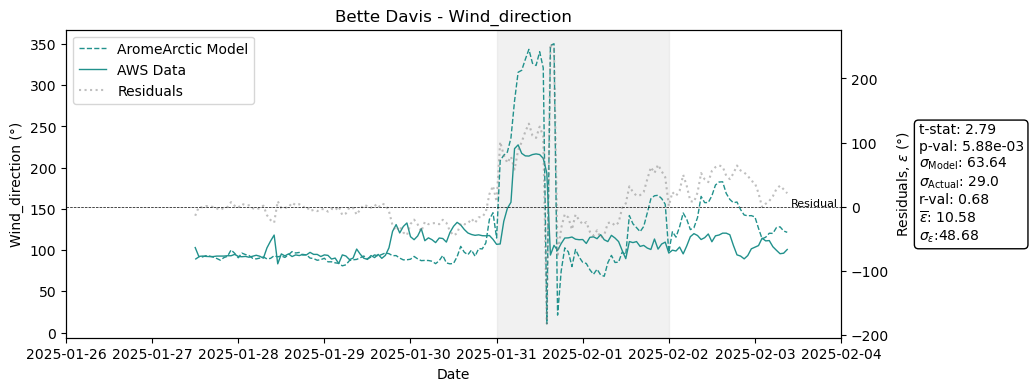

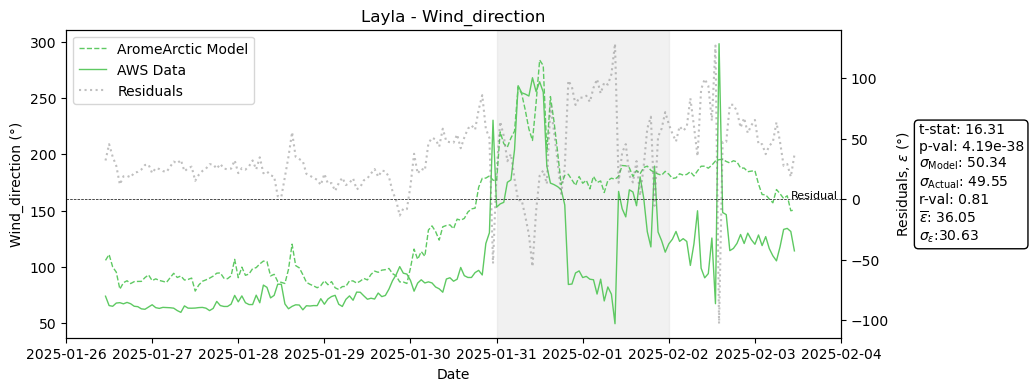

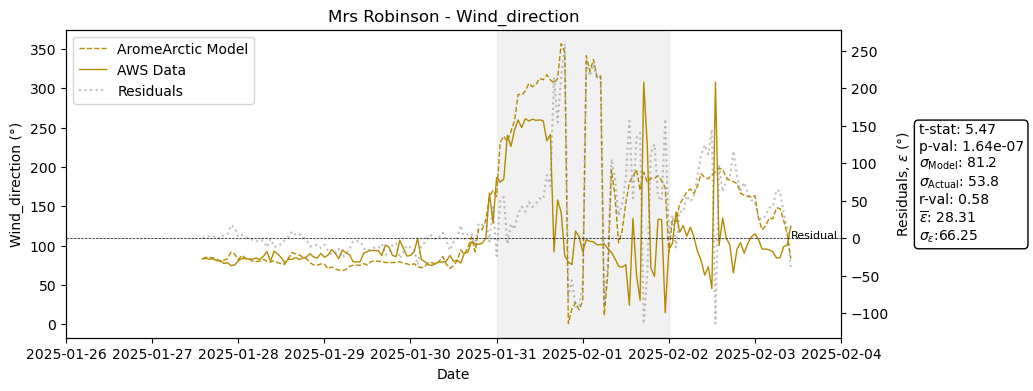

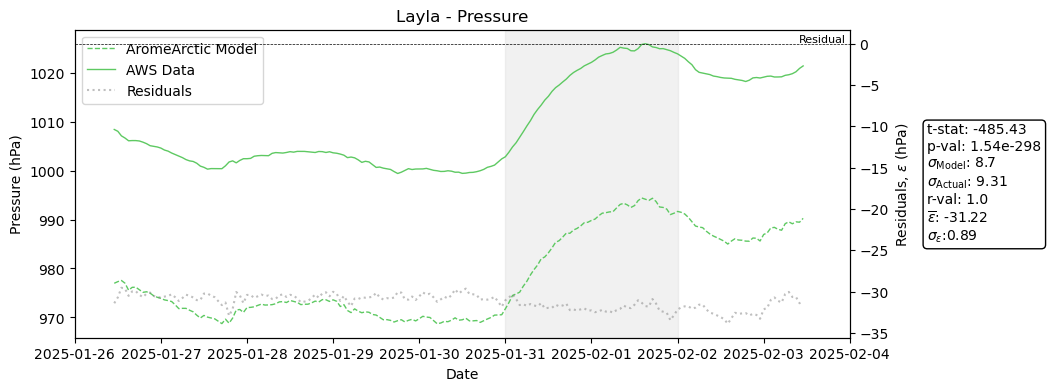

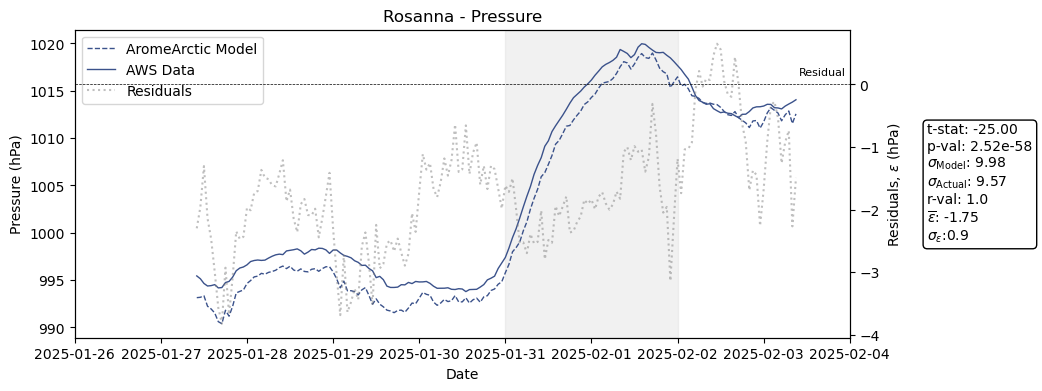

In [6]:
def plot_timeseries_with_residuals(variable):
    """
    Plots time series of AWS and model data for a given variable and overlays residuals on a secondary y-axis.
    Adds a shaded area for January 31st to February 1st.
    
    Parameters:
    - variable (str): "temperature", "wind_speed", "wind_direction", "pressure".
    
    Returns:
    - results (dict): Dictionary containing model data, actual data, residuals, and statistics for each station.
    """
    
    global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

    stations_str = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
    stations_to_plot = ["Layla", "Rosanna"]  # Used for pressure only

    # Determine which stations to plot
    if variable == "pressure":
        stations = stations_to_plot
    else:
        stations = stations_str

    # Variable mappings
    variable_mapping = {
        "temperature": {"aws_key": "temperature", "arome_key": "air_temperature_2m", "unit": "°C", "convert": lambda x: x - 273.15},
        "wind_speed": {"aws_key": "calibrated_wind_speed", "arome_key": "wind_speed_10m", "unit": "m/s", "convert": lambda x: x},
        "wind_direction": {"aws_key": "wind_direction", "arome_key": "wind_direction_10m", "unit": "°", "convert": lambda x: x},
        "pressure": {"aws_key": "calibrated_air_pressure", "arome_key": "surface_air_pressure", "unit": "hPa", "convert": lambda x: x / 100},
    }

    if variable not in variable_mapping:
        raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")
    
    aws_key = variable_mapping[variable]["aws_key"]
    arome_key = variable_mapping[variable]["arome_key"]
    unit = variable_mapping[variable]["unit"]
    convert_func = variable_mapping[variable]["convert"]
    
    results = {}
    
    for i, station in enumerate(stations):
        fig, ax1 = plt.subplots(figsize=(10, 4))
        
        station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
        station_lat = station_data["LAT (dec deg)"].values[0]
        station_lon = station_data["LON (dec deg)"].values[0]
        
        # Find closest model grid point
        abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
        abs_diff_np = abs_diff.values
        y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
        
        timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))
        model_data = timeseries.to_series()
        actual_data = aws_hourly_data[station][aws_key]
        model_data, actual_data = match_data_length(model_data, actual_data)
        
        errors = model_data - actual_data
        stats = compute_t_stat(errors)
        r_value, _ = pearsonr(model_data, actual_data)
        r_value = round(r_value, 2)
        
        model_std = round(np.std(model_data), 2)
        actual_std = round(np.std(actual_data), 2)

        error_mean = round(np.mean(errors), 2)
        error_std = round(np.std(errors), 2)

        min_model = np.min(model_data)
        max_model = np.max(model_data)

        min_actual = np.min(actual_data)
        max_actual = np.max(actual_data)

        results[station] = {
            "model_data": model_data,
            "actual_data": actual_data,
            "errors": errors,
            "t-statistic": stats["tstat"],
            "p-value": stats["pval"],
            "r-value": r_value,
            "error_mean": error_mean,
            "error_std": error_std,
            "min_model": min_model,
            "max_model": max_model,
            "min_actual": min_actual,
            "max_actual": max_actual
        }

        # **Shaded Area (January 31st - February 1st)**
        start_date = pd.Timestamp("2025-01-31 00:00:00")
        end_date = pd.Timestamp("2025-02-02 00:00:00")
        ax1.axvspan(start_date, end_date, color='lightgray', alpha=0.3, label="Highlighted Period")

        # Left Y-Axis: Model vs. Actual Data
        if variable == "pressure":
            color_idx1 = ['#5ec962', '#3b528b']
            model_line, = ax1.plot(model_data.index, model_data, label='AromeArctic Model', linewidth=1, color=color_idx1[i], linestyle='--')
            actual_line, = ax1.plot(actual_data.index, actual_data, label='AWS Data', linewidth=1, color=color_idx1[i], linestyle='-')
        else:
            model_line, = ax1.plot(model_data.index, model_data, label='AromeArctic Model', linewidth=1, color=color_idx[i], linestyle='--')
            actual_line, = ax1.plot(actual_data.index, actual_data, label='AWS Data', linewidth=1, color=color_idx[i], linestyle='-')
        ax1.set_ylabel(f"{variable.capitalize()} ({unit})")
        ax1.set_xlabel("Date")

        # Right Y-Axis: Residuals
        ax2 = ax1.twinx()
        residual_line, = ax2.plot(actual_data.index, errors, color='grey', linestyle=':', alpha=0.5, label="Residuals")
        ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax2.text(
            x= pd.Timestamp('2025-02-03 23:00:00'), #actual_data.index[-1],  # Position near the right edge
            y=0.15,  # Slightly below the zero line
            s="Residual", 
            fontsize=8, 
            color="black",
            ha='right'  # Align text to the right
        )
        
        ax2.set_ylabel("Residuals, "r'$\epsilon$ ' f'({unit})')

        ax1.set_title(f"{station} - {variable.capitalize()}")

        ax1.set_xlim(pd.Timestamp("2025-01-26"), pd.Timestamp("2025-02-04"))

        # **Combine both legends**
        lines = [model_line, actual_line, residual_line]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc="upper left")

        # **Display statistical summary**
        stats_text = (
            f"t-stat: {stats['tstat']:.2f}\n"
            f"p-val: {stats['pval']:.2e}\n"
            r"$\sigma_{\text{Model}}$: " f"{model_std}\n"
            r"$\sigma_{\text{Actual}}$: " f"{actual_std}\n"
            f'r-val: {r_value}\n'
            f'$\overline{{\epsilon}}$: {error_mean}\n'
            r'$\sigma_{\epsilon}$:' f'{error_std}'
        )
        ax1.text(1.1, 0.5, stats_text, transform=ax1.transAxes, fontsize=10,
                 verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

        save_figure(fig, '../figs/', f'modelValidation_{variable}_{station}')

    return results


# Generate plots for all variables with residuals and statistics
temp_data = plot_timeseries_with_residuals("temperature")
windSpeed_data = plot_timeseries_with_residuals("wind_speed")
windDirection_data = plot_timeseries_with_residuals("wind_direction")
pressure_data = plot_timeseries_with_residuals("pressure")


# Comuting stats parameeter stats for table

In [7]:
# Model table
data = {
    "AromeArctic gridpoint": stations_str,
    "Min Temp (degC)": [temp_data[station]['min_model'] for station in stations_str],
    "Max Temp (degC)": [temp_data[station]['max_model'] for station in stations_str],
    "Min Pressure (hPa)": [
        pressure_data[station]['min_model'] if station in stations_to_plot else None 
        for station in stations_str
    ],
    "Max Pressure (hPa)": [
        pressure_data[station]['max_model'] if station in stations_to_plot else None 
        for station in stations_str
    ],
    "Min Wind speed (m/s)": [windSpeed_data[station]['min_model'] for station in stations_str],
    "Max Wind speed (m/s)": [windSpeed_data[station]['max_model'] for station in stations_str],
}

# Convert to DataFrame
df = pd.DataFrame(data)


# Print the table
print(df.to_string(index=False))  # Display table without index


AromeArctic gridpoint  Min Temp (degC)  Max Temp (degC)  Min Pressure (hPa)  Max Pressure (hPa)  Min Wind speed (m/s)  Max Wind speed (m/s)
             Tom Joad        -7.114288         2.809174                 NaN                 NaN              1.257219             15.576030
              Rosanna        -5.079742         2.857025          990.394836         1018.987366              0.733941             18.573759
          Bette Davis        -5.940460         2.265869                 NaN                 NaN              1.328652             16.821520
                Layla        -8.110382         1.185791          968.715942          994.399658              1.026894             15.993053
         Mrs Robinson        -8.090179        -0.430420                 NaN                 NaN              0.424953             16.849790


In [8]:
# Actual data table
data = {
    "Station": stations_str,
    "Min Temp (degC)": [temp_data[station]['min_actual'] for station in stations_str],
    "Max Temp (degC)": [temp_data[station]['max_actual'] for station in stations_str],
    "Min Pressure (hPa)": [
        pressure_data[station]['min_actual'] if station in stations_to_plot else None 
        for station in stations_str
    ],
    "Max Pressure (hPa)": [
        pressure_data[station]['max_actual'] if station in stations_to_plot else None 
        for station in stations_str
    ],
    "Min Wind speed (m/s)": [windSpeed_data[station]['min_actual'] for station in stations_str],
    "Max Wind speed (m/s)": [windSpeed_data[station]['max_actual'] for station in stations_str],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Print the table
print(df.to_string(index=False))  # Display table without index


     Station  Min Temp (degC)  Max Temp (degC)  Min Pressure (hPa)  Max Pressure (hPa)  Min Wind speed (m/s)  Max Wind speed (m/s)
    Tom Joad        -6.699861         4.090924                 NaN                 NaN              1.249344             10.099055
     Rosanna        -9.465337         4.092180          993.788304         1019.970254              0.815965             12.442542
 Bette Davis       -11.888072         4.000972                 NaN                 NaN              0.937583             13.836458
       Layla        -8.476900         3.819417          999.398835         1025.900001              0.972708             14.318880
Mrs Robinson       -10.842948         3.984414                 NaN                 NaN              0.618072             14.062487


In [9]:
np.mean(windDirection_data['Mrs Robinson']['actual_data'])

np.float64(109.25241871480641)

# Generating temperature anomaly array, for map stations

In [10]:
# Load tinytag data
tinytag_path = load_path() + 'CalibratedData/TinyTag/'

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(tinytag_path, "*.csv"))

# Dictionary to store DataFrames
TinyTag_data = {}

# Load each CSV file into a DataFrame
for file in csv_files:
    file_name = os.path.basename(file)  # Extract filename without path
    TinyTag_data[file_name] = pd.read_csv(file)  # Load CSV into dictionary


In [11]:
# Convert to correct format
TinyTag_str = ['TH1', 'TH2', 'TH3', 'TH5', 'TH6']#, 'TH8']

# Dictionary to store transformed DataFrames
transformed_data = {}

for file_name, df in TinyTag_data.items():
    # Extract station name (TH1, TH2, etc.) from file_name
    match = re.search(r"TH\d+", file_name)
    
    if match:
        station_name = match.group(0)  # Extract matched station (e.g., "TH1")

        if station_name in TinyTag_str:
            # Convert TIMESTAMP to datetime and set as index
            df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
            df = df.set_index("TIMESTAMP")

            # Store transformed DataFrame with proper station name
            transformed_data[station_name] = df

# Replace TinyTag_data with the transformed version
TinyTag_data = transformed_data

In [12]:
# Resample to houly data
tinytag_hourly_data = {}

for i, station in enumerate(TinyTag_str):
    tinytag_hourly_data[station] = TinyTag_data[station].resample('h').mean()
    # Add a column for station name
    tinytag_hourly_data[station]['Station'] = station 

<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:122: SyntaxWarning: invalid escape sequence '\e'
<>:122: SyntaxWarning: invalid escape sequence '\o'
<>:122: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alber\AppData\Local\Temp\ipykernel_31048\2066387121.py:122: SyntaxWarning: invalid escape sequence '\o'
  f'$\overline{{\epsilon}}$: {error_mean}\n'
C:\Users\alber\AppData\Local\Temp\ipykernel_31048\2066387121.py:122: SyntaxWarning: invalid escape sequence '\e'
  f'$\overline{{\epsilon}}$: {error_mean}\n'


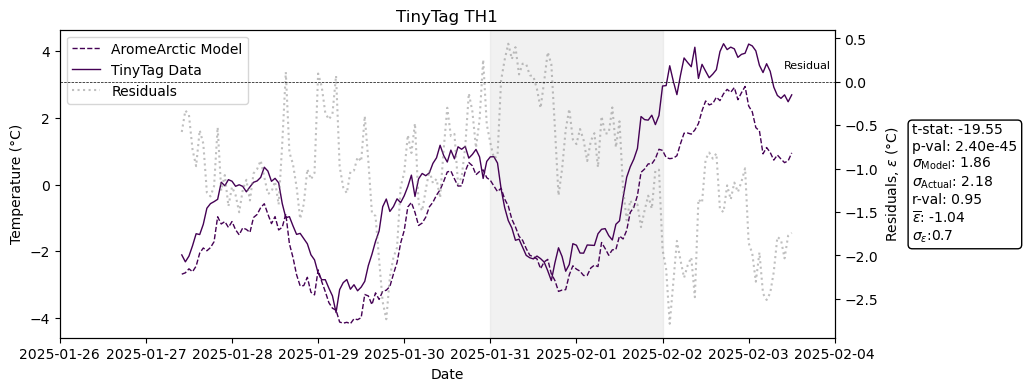

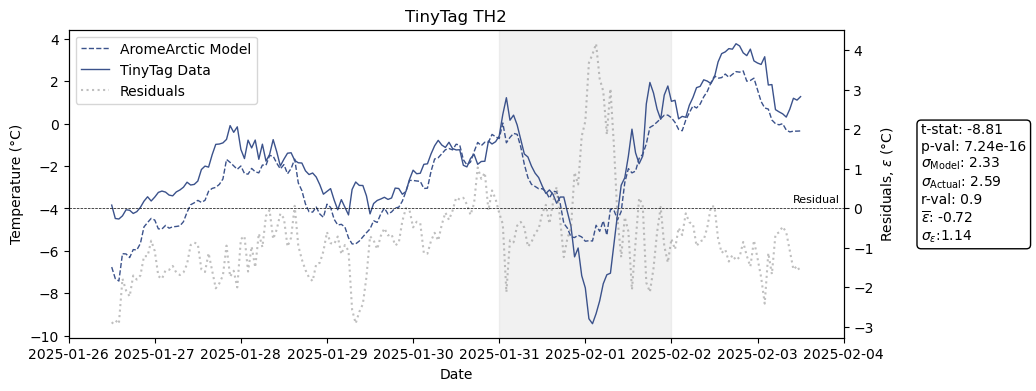

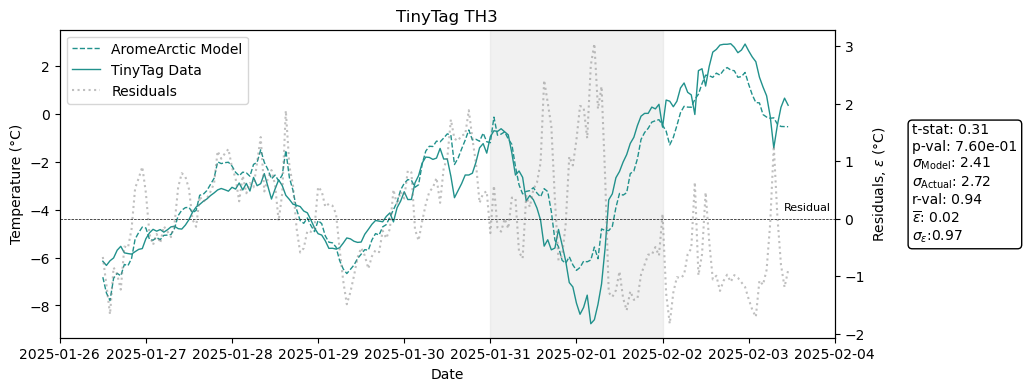

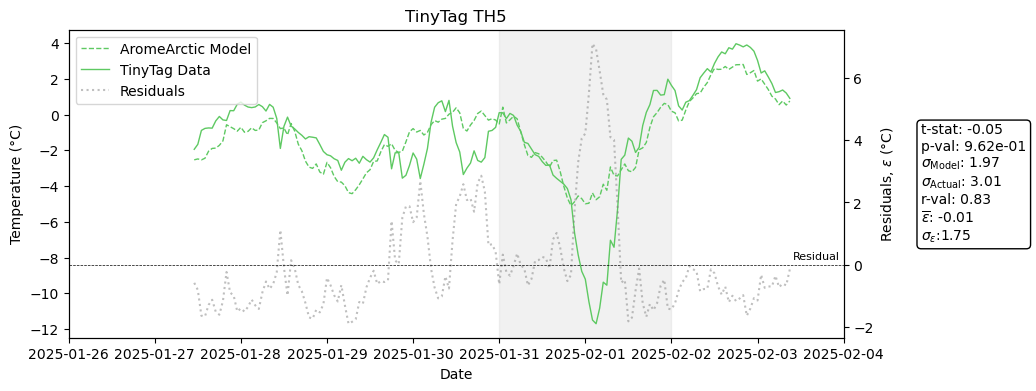

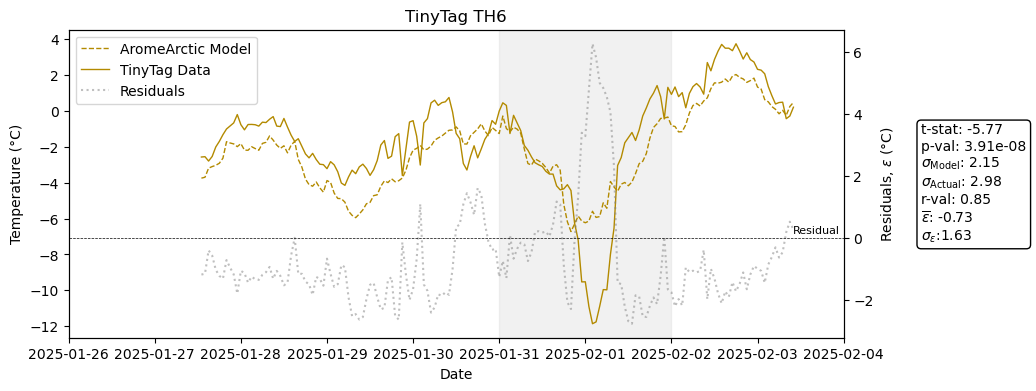

In [ ]:
def plot_tinytag_timeseries_with_residuals():
    """
    Plots time series of TinyTag temperature data and overlays residuals on a secondary y-axis.
    Adds a shaded area for January 31st to February 1st.

    Returns:
    - results (dict): Dictionary containing model data, actual data, residuals, and statistics for each TinyTag station.
    """

    global tinytag_hourly_data, aromeArctic_data, color_idx, match_data_length

    # List of TinyTag stations
    # TinyTag_str = ['TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8']

    # Variable mappings for TinyTag
    aws_key = "Calibrated_Temperature"
    arome_key = "air_temperature_2m"
    unit = "°C"
    convert_func = lambda x: x - 273.15  # Convert Kelvin to Celsius

    results = {}

    for i, station in enumerate(TinyTag_str):
        fig, ax1 = plt.subplots(figsize=(10, 4))

        # Find closest model grid point
        # station_data = tinytag_hourly_data[station]
        # station_lat = station_data["LAT (dec deg)"].values[0]
        # station_lon = station_data["LON (dec deg)"].values[0]
        
        # Extract lat/lon for TinyTag stations
        station_data = instrument_textbook_data[instrument_textbook_data["Station name"].str.startswith(station)]
        station_lat = station_data["LAT (dec deg)"].values[0]
        station_lon = station_data["LON (dec deg)"].values[0]


        abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
        abs_diff_np = abs_diff.values
        y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

        timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))
        model_data = timeseries.to_series()
        actual_data = tinytag_hourly_data[station][aws_key]
        model_data, actual_data = match_data_length(model_data, actual_data)

        # Compute residuals and statistics
        errors = model_data - actual_data
        stats = compute_t_stat(errors)
        r_value, _ = pearsonr(model_data, actual_data)
        r_value = round(r_value, 2)

        model_std = round(np.std(model_data), 2)
        actual_std = round(np.std(actual_data), 2)

        error_mean = round(np.mean(errors), 2)
        error_std = round(np.std(errors), 2)

        min_model = np.min(model_data)
        max_model = np.max(model_data)

        min_actual = np.min(actual_data)
        max_actual = np.max(actual_data)

        results[station] = {
            "model_data": model_data,
            "actual_data": actual_data,
            "errors": errors,
            "t-statistic": stats["tstat"],
            "p-value": stats["pval"],
            "r-value": r_value,
            "error_mean": error_mean,
            "error_std": error_std,
            "min_model": min_model,
            "max_model": max_model,
            "min_actual": min_actual,
            "max_actual": max_actual
        }

        # **Shaded Area (January 31st - February 1st)**
        start_date = pd.Timestamp("2025-01-31 00:00:00")
        end_date = pd.Timestamp("2025-02-02 00:00:00")
        ax1.axvspan(start_date, end_date, color='lightgray', alpha=0.3, label="Highlighted Period")

        # Left Y-Axis: Model vs. Actual Data
        model_line, = ax1.plot(model_data.index, model_data, label='AromeArctic Model', linewidth=1, color=color_idx[i], linestyle='--')
        actual_line, = ax1.plot(actual_data.index, actual_data, label='TinyTag Data', linewidth=1, color=color_idx[i], linestyle='-')

        ax1.set_ylabel(f"Temperature ({unit})")
        ax1.set_xlabel("Date")

        # Right Y-Axis: Residuals
        ax2 = ax1.twinx()
        residual_line, = ax2.plot(actual_data.index, errors, color='grey', linestyle=':', alpha=0.5, label="Residuals")
        ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax2.text(
            x=pd.Timestamp('2025-02-03 23:00:00'),
            y=0.15,
            s="Residual",
            fontsize=8,
            color="black",
            ha='right'
        )

        ax2.set_ylabel("Residuals, "r'$\epsilon$ ' f'({unit})')

        ax1.set_title(f"TinyTag {station}")

        ax1.set_xlim(pd.Timestamp("2025-01-26"), pd.Timestamp("2025-02-04"))

        # **Combine both legends**
        lines = [model_line, actual_line, residual_line]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc="upper left")

        # **Display statistical summary**
        stats_text = (
            f"t-stat: {stats['tstat']:.2f}\n"
            f"p-val: {stats['pval']:.2e}\n"
            r"$\sigma_{\text{Model}}$: " f"{model_std}\n"
            r"$\sigma_{\text{Actual}}$: " f"{actual_std}\n"
            f'r-val: {r_value}\n'
            f'$\overline{{\epsilon}}$: {error_mean}\n'
            r'$\sigma_{\epsilon}$:' f'{error_std}'
        )
        ax1.text(1.1, 0.5, stats_text, transform=ax1.transAxes, fontsize=10,
                 verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

        save_figure(fig, '../figs/', f'modelValidation_tinytag_temperature_{station}')

    return results


# Generate TinyTag plots for temperature
tinytag_temp_data = plot_tinytag_timeseries_with_residuals()


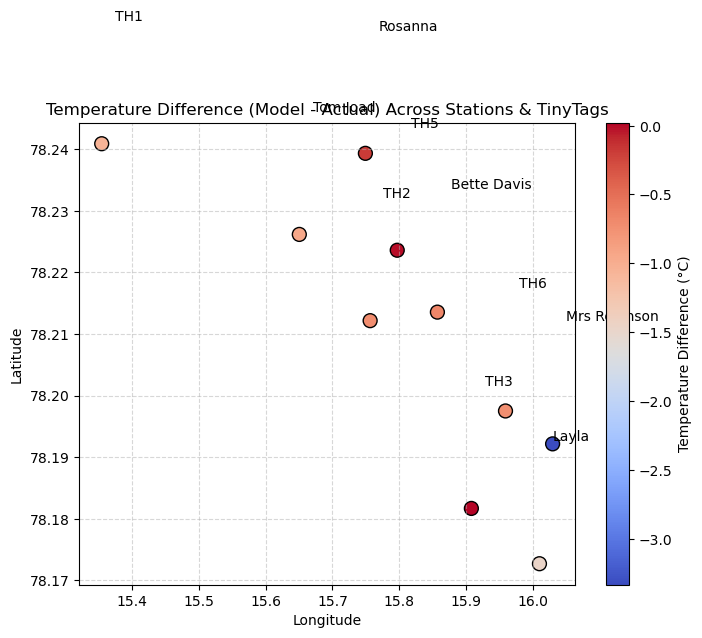

In [14]:
# Initialize lists for storing station data
lats = []
lons = []
temp_diffs = []

# Combine AWS stations and TinyTag stations
all_stations = stations_str + TinyTag_str

for station in all_stations:
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    
    if station_data.empty:
        continue  # Skip if no data for the station
    
    # Extract latitude and longitude
    lat = station_data["LAT (dec deg)"].values[0]
    lon = station_data["LON (dec deg)"].values[0]
    
    # Compute mean temperature difference (Model - Actual)
    if station in temp_data:
        temp_diff = np.mean(temp_data[station]['errors'])  # AWS station data
    elif station in tinytag_temp_data:
        temp_diff = np.mean(tinytag_temp_data[station]['errors'])  # TinyTag station data
    else:
        continue  # Skip if no temperature data available

    # Append extracted data
    lats.append(lat)
    lons.append(lon)
    temp_diffs.append(temp_diff)

# Convert lists to numpy arrays
lats = np.array(lats)
lons = np.array(lons)
temp_diffs = np.array(temp_diffs)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(lons, lats, c=temp_diffs, cmap='coolwarm', edgecolors='black', s=100)

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Temperature Difference (°C)")

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Temperature Difference (Model - Actual) Across Stations & TinyTags")

# Add station names next to points
for i, station in enumerate(all_stations):
    ax.text(lons[i] + 0.02, lats[i] + 0.02, station, fontsize=10, ha='left')

# Show plot
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [15]:
temp_diffs_df = pd.DataFrame({
    "Station Name": stations_str+TinyTag_str,
    "Temperature Difference (°C)": temp_diffs
})

# Save to CSV file
csv_filename = load_path() + "temperature_differences.csv"
temp_diffs_df.to_csv(csv_filename, index=False)

# print(f"CSV file saved as {csv_filename}")

In [23]:
# Model table
data = {
    "AromeArctic gridpoint": TinyTag_str,
    "Min Temp (degC)": [tinytag_temp_data[station]['min_model'] for station in TinyTag_str],
    "Max Temp (degC)": [tinytag_temp_data[station]['max_model'] for station in TinyTag_str],
}

# Convert to DataFrame
df = pd.DataFrame(data)


# Print the table
print(df.to_string(index=False))  # Display table without index


AromeArctic gridpoint  Min Temp (degC)  Max Temp (degC)
                  TH1        -4.172943         2.944427
                  TH2        -7.417999         2.479095
                  TH3        -7.793976         1.948486
                  TH5        -5.097687         2.800385
                  TH6        -6.722687         2.039307


In [24]:
# Actual table
data = {
    "Data": TinyTag_str,
    "Min Temp (degC)": [tinytag_temp_data[station]['min_actual'] for station in TinyTag_str],
    "Max Temp (degC)": [tinytag_temp_data[station]['max_actual'] for station in TinyTag_str],
}

# Convert to DataFrame
df = pd.DataFrame(data)


# Print the table
print(df.to_string(index=False))  # Display table without index


Data  Min Temp (degC)  Max Temp (degC)
 TH1        -3.837983         4.226683
 TH2        -9.429833         3.760650
 TH3        -8.762517         2.945283
 TH5       -11.704200         3.962083
 TH6       -11.867083         3.757483
